<a href="https://colab.research.google.com/github/Melo987/-v2/blob/main/11_%E6%A8%A1%E5%9E%8B%E9%80%89%E6%8B%A9%2B%E8%BF%87%E6%8B%9F%E5%90%88%E5%92%8C%E6%AC%A0%E6%8B%9F%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**模型选择**

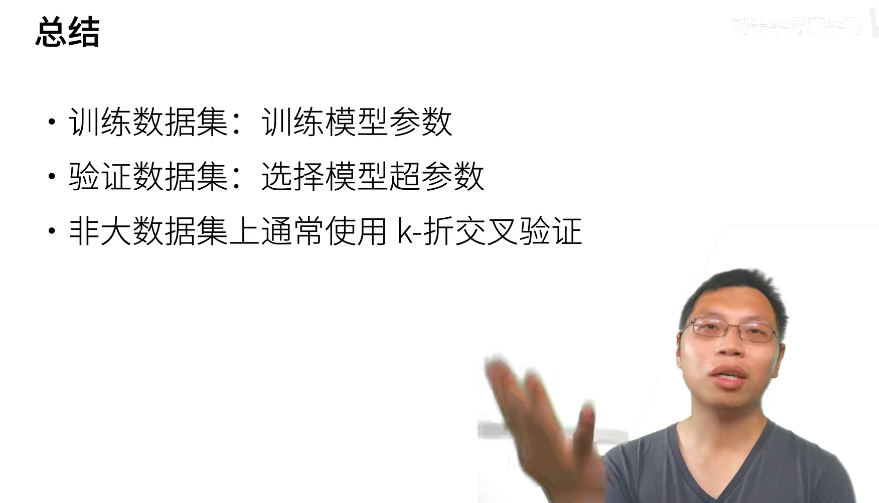

**过拟合和欠拟合**

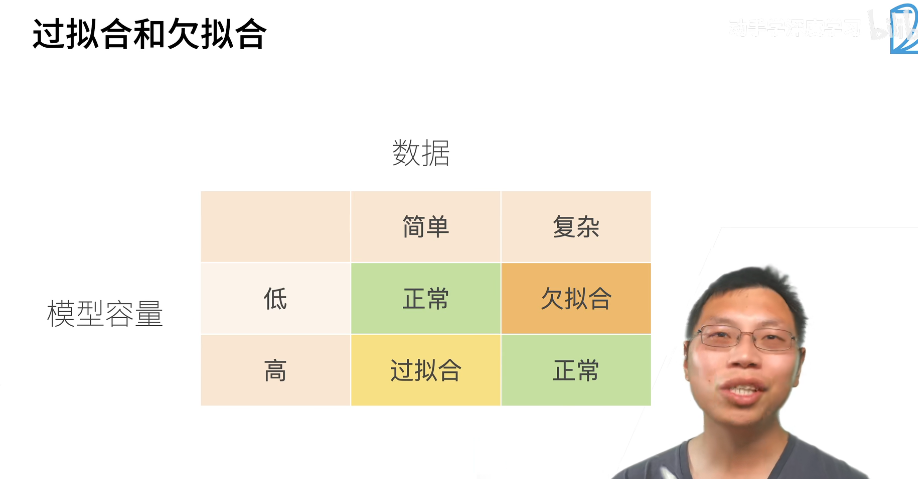

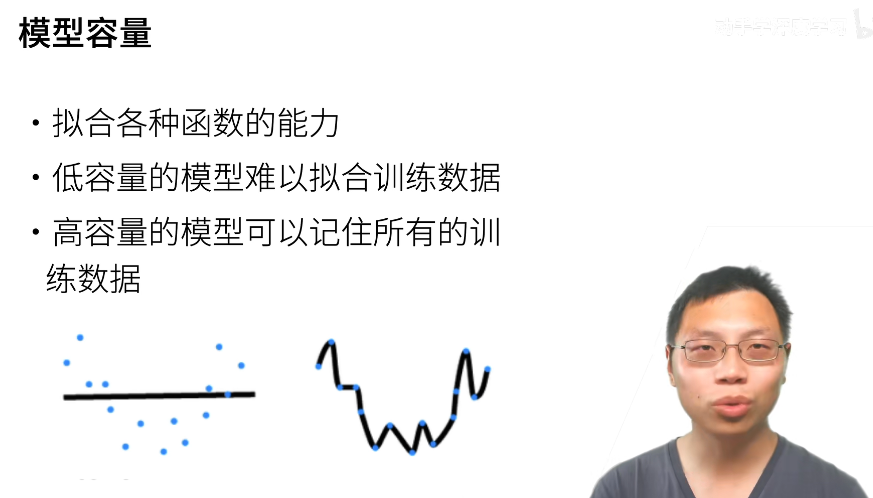

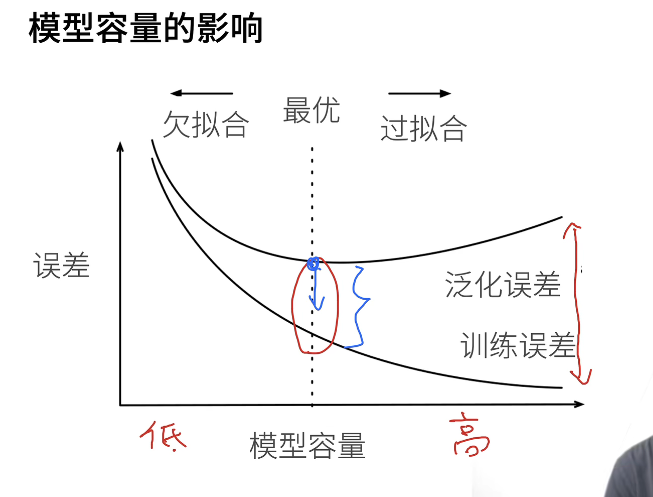

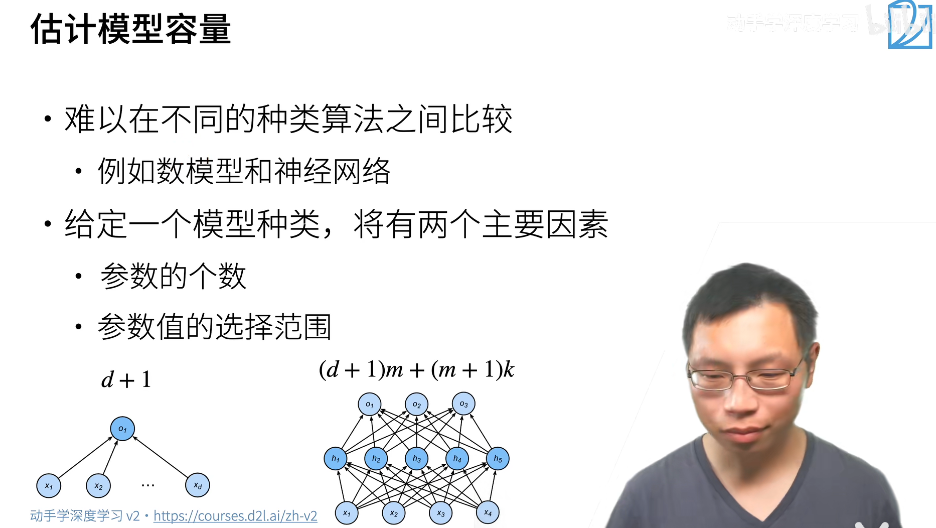

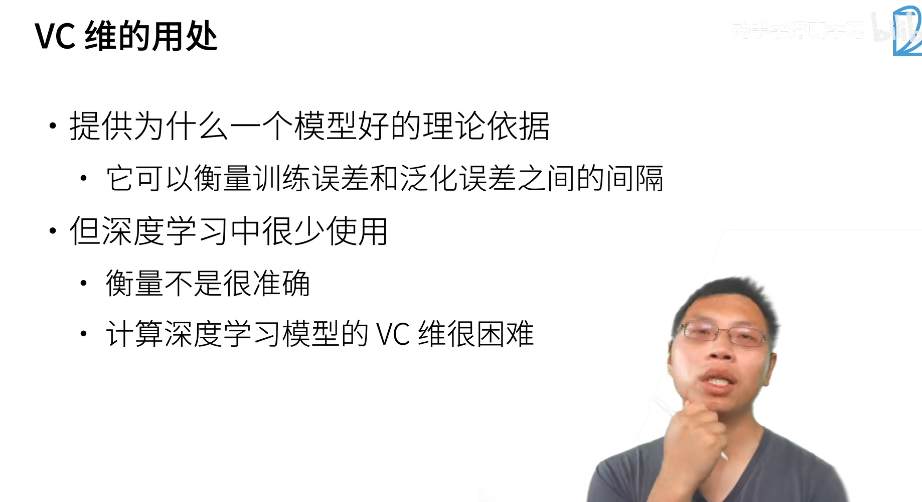

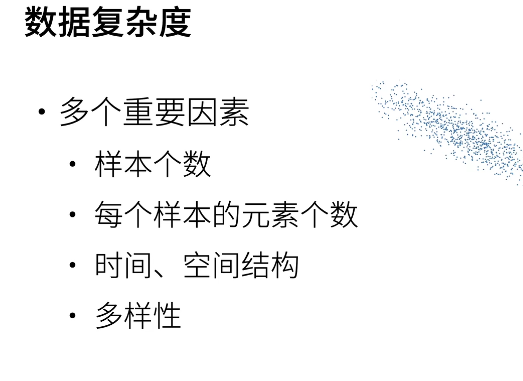

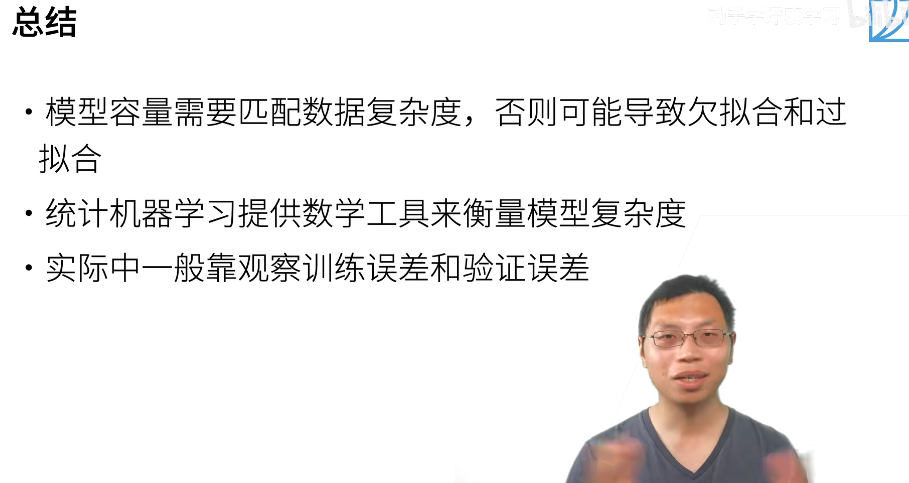

# 代码

In [2]:
!pip install -U d2l

In [11]:
!pip install matplotlib==3.0.

In [3]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

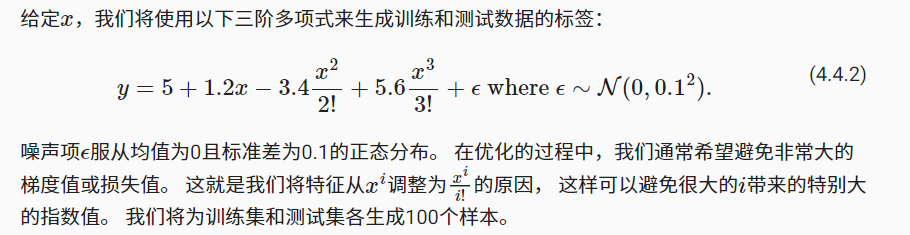

In [5]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集的大小
true_w = np.zeros(max_degree)  #分配大量的空间
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [6]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.3024],
         [0.0017]]),
 tensor([[1.0000e+00, 3.0242e-01, 4.5730e-02, 4.6099e-03, 3.4854e-04, 2.1081e-05,
          1.0626e-06, 4.5907e-08, 1.7354e-09, 5.8314e-11, 1.7635e-12, 4.8485e-14,
          1.2219e-15, 2.8426e-17, 6.1405e-19, 1.2380e-20, 2.3400e-22, 4.1628e-24,
          6.9941e-26, 1.1132e-27],
         [1.0000e+00, 1.7327e-03, 1.5012e-06, 8.6706e-10, 3.7560e-13, 1.3016e-16,
          3.7589e-20, 9.3047e-24, 2.0153e-27, 3.8800e-31, 6.7231e-35, 1.0590e-38,
          1.5288e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00]]),
 tensor([5.2701, 5.2058]))

In [7]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [8]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0012445  1.2239535 -3.3842492  5.589527 ]]


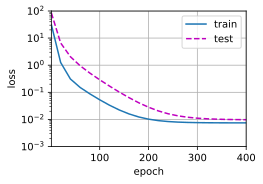

In [12]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.347248 4.324714]]


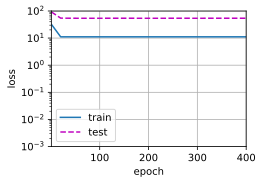

In [13]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9947505   1.2868834  -3.3666656   5.2545233  -0.02759586  0.9635589
   0.2834564   0.15342416  0.10184968  0.06794605 -0.13729234 -0.16738151
   0.07170537  0.10745023  0.09617407  0.02289265  0.1599887   0.10361061
  -0.09040547  0.18242556]]


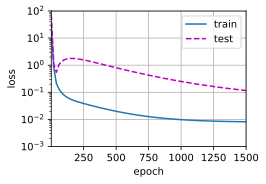

In [15]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)